In [52]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, rgb_to_hsv, LinearSegmentedColormap
import numpy as np
from collections import defaultdict
from itertools import combinations
import random
import subprocess

# Parameters settings
Adjust the parameters in the first code block with the ones you prefer.
Then specify your graph path and the saving directory.

In [57]:
max_iter = 50_000_000
max_num_group = 5
initial_num_group = 2
gml_path = "./Graphs/sw_ep3_interactions.gml"
saved_data_name = "sw_ep3_interactions_cp_5"
save_directory = "Outputs/sw_ep3_interactions_5/"

config_path = save_directory + saved_data_name + "_configs.txt"
num_groups_path = save_directory + saved_data_name + "_num_groups.txt"
ll_path = save_directory + saved_data_name + "_ll.txt"

new_values = {
    "gml_path": gml_path,
    "max_itr": max_iter,
    "max_num_groups": max_num_group,
    "initial_num_groups": initial_num_group,
    "saved_data_name": saved_data_name,
    "save_directory": save_directory
}

with open("parameters.txt", "r+") as f:
    lines = f.readlines()
    f.seek(0)
    f.truncate()
    
    for line in lines:
        key = line.split(":")[0].strip()
        if key in new_values:
            f.write(f"{key}: {new_values[key]}\n")
        else:
            f.write(line)

# Run program

In [54]:
path_exe = "build/hcp.exe"
subprocess.run([path_exe, "parameters.txt"])

CompletedProcess(args=['build/hcp.exe', 'parameters.txt'], returncode=0)

# 2 groups plotting

Minimum log likelihood: -128.048 at index 25901
Best config: [3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1]
Best number of groups: 2


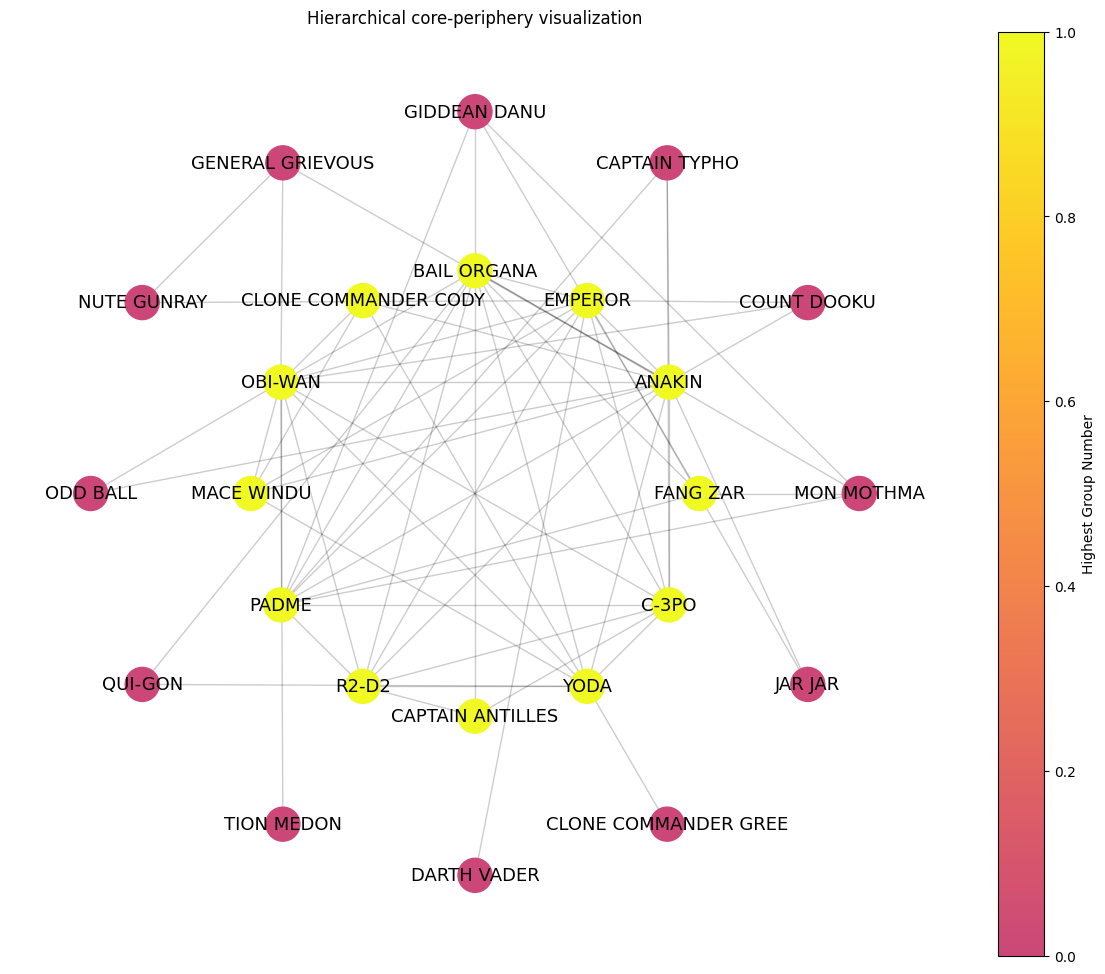

In [60]:
with open(ll_path, "r") as f:
    lines = f.readlines()
    min_ll = float("inf")
    min_ll_index = 0
    for i, line in enumerate(lines):
        ll = float(line.strip())
        if ll < min_ll:
            min_ll = ll
            min_ll_index = i
    print(f"Minimum log likelihood: {min_ll} at index {min_ll_index}")

with open(config_path, "r") as f:
    lines = f.readlines()
    best_config = lines[min_ll_index].strip()
    best_config = list(map(int, best_config.split()))
    print(f"Best config: {best_config}")

with open(num_groups_path, "r") as f:
    lines = f.readlines()
    best_num_groups = int(lines[min_ll_index].strip())
    print(f"Best number of groups: {best_num_groups}")

if best_num_groups == 2:
    def truncate_colormap(cmap, min_val=0.2, max_val=1.0, n=100):
        new_cmap = LinearSegmentedColormap.from_list(
            f"trunc({cmap.name},{min_val:.2f},{max_val:.2f})",
            cmap(np.linspace(min_val, max_val, n))
        )
        return new_cmap

    def get_node_groups(number):
        binary = format(number, 'b')[::-1]
        return [i for i, bit in enumerate(binary) if bit == '1']

    def create_group_based_layout(G, numbers):
        node_list = list(G.nodes())
        node_to_idx = {node: idx for idx, node in enumerate(node_list)}
        idx_to_node = {idx: node for idx, node in enumerate(node_list)}
        
        node_groups = {}
        for i, num in enumerate(numbers):
            if i < len(node_list):
                node_groups[node_list[i]] = get_node_groups(num)
        
        # Calculate hierarchical level based on number of groups a node belongs to
        hierarchy_levels = {node: len(groups) for node, groups in node_groups.items()}
        max_level = max(hierarchy_levels.values()) if hierarchy_levels else 1
        
        pos = nx.spring_layout(G, k=1, iterations=50)
        # Adjust positions based on hierarchy levels
        for level in range(max_level + 1):
            # Count nodes at this level
            level_nodes = [(i, node) for i, node in enumerate(G.nodes()) if hierarchy_levels.get(node, 0) == level]
            n_level_nodes = len(level_nodes)
            
            if n_level_nodes == 0:
                continue
                
            angle_step = 2 * np.pi / n_level_nodes  # Equal spacing in a circle
            
            # Calculate radius for this level with margin
            margin = 0.1  # Adjust this value to increase or decrease spacing
            if level < max_level:
                base_radius = 1 - (level / max_level)
            else:
                base_radius = 0.25
            radius = base_radius + margin
            
            # Position nodes at this level
            for idx, (i, node) in enumerate(level_nodes):
                theta = idx * angle_step  # Unique angle for each node at this level
                pos[node] = np.array([radius * np.cos(theta), radius * np.sin(theta)])

        fig, ax = plt.subplots(figsize=(15, 12))
        
        # Node sizes based on number of groups
        node_sizes = [600 for node in G.nodes()]
        
        # Node colors based on highest group number
        node_colors = [max(node_groups.get(node, [0])) if node_groups.get(node, []) else 0 
                    for node in G.nodes()]

        truncated_cmap = truncate_colormap(plt.cm.plasma, min_val=0.5, max_val=1.0)

        nodes = nx.draw_networkx_nodes(G, pos, 
                                    node_size=node_sizes,
                                    node_color=node_colors,
                                    cmap=truncated_cmap,
                                    ax=ax)
        
        nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax)
        
        # Set up colorbar
        norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
        sm = plt.cm.ScalarMappable(cmap=truncated_cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label="Highest Group Number")

        labels = {node: str(node) for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_color='black', font_size=13, ax=ax)

        plt.title("Hierarchical core-periphery visualization")
        plt.axis('off')
        
        return G, pos

    G = nx.read_gml(gml_path)
    G, pos = create_group_based_layout(G, best_config)
    plt.show()

else:
    print("Cannot visualize more than 2 groups")

# Get nodes groups 

In [62]:
G = nx.read_gml(gml_path)

with open(ll_path, "r") as f:
    lines = f.readlines()
    min_ll = float("inf")
    min_ll_index = 0
    for i, line in enumerate(lines):
        ll = float(line.strip())
        if ll < min_ll:
            min_ll = ll
            min_ll_index = i

with open(config_path, "r") as f:
    lines = f.readlines()
    best_config = lines[min_ll_index].strip()
    best_config = list(map(int, best_config.split()))

with open(num_groups_path, "r") as f:
    lines = f.readlines()
    best_num_groups = int(lines[min_ll_index].strip())

print(f"Minimum log likelihood: {min_ll} at index {min_ll_index}")
print(f"Configuration: {best_config}")
print(f"Number of groups: {best_num_groups}")

groups = {}
for node_index, value in enumerate(best_config):
    binary_value = bin(value)[2:].zfill(5)[::-1]
    if binary_value not in groups:
        groups[binary_value] = []
    groups[binary_value].append(node_index)

groups_with_labels = {}
for binary_value, node_indices in groups.items():
    # Map node indices to their labels
    node_labels = [list(G.nodes)[node_index] for node_index in node_indices]
    groups_with_labels[binary_value] = node_labels

print("\nGroups with Node Labels:")
for binary_value, nodes in groups_with_labels.items():
    print(f"Binary Value {binary_value}: Nodes {nodes}")

for binary_value, nodes in groups_with_labels.items():
    for node in nodes:
        if node in G.nodes:
            G.nodes[node]["binary_value"] = binary_value

with open(save_directory + saved_data_name + "_groups_with_labels.txt", "w") as f:
    for binary_value, nodes in groups_with_labels.items():
        f.write(f"Binary Value {binary_value}: Nodes {', '.join(nodes)}\n")

Minimum log likelihood: -128.048 at index 25901
Configuration: [3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1]
Number of groups: 2

Groups with Node Labels:
Binary Value 11000: Nodes ['FANG ZAR', 'ANAKIN', 'EMPEROR', 'BAIL ORGANA', 'CLONE COMMANDER CODY', 'OBI-WAN', 'MACE WINDU', 'PADME', 'R2-D2', 'CAPTAIN ANTILLES', 'YODA', 'C-3PO']
Binary Value 10000: Nodes ['MON MOTHMA', 'COUNT DOOKU', 'CAPTAIN TYPHO', 'GIDDEAN DANU', 'GENERAL GRIEVOUS', 'NUTE GUNRAY', 'ODD BALL', 'QUI-GON', 'TION MEDON', 'DARTH VADER', 'CLONE COMMANDER GREE', 'JAR JAR']
